This is a UNET segmentation model, based on implementation in 'Segmentation Zoo'

https://github.com/dbuscombe-usgs/segmentation_zoo

Use Doodler to get labels for your images: https://github.com/dbuscombe-usgs/dash_doodler


In [1]:
# import the packages we need...
#first, the general stuff
import os
from os import getcwd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.8.0


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [3]:
#define the number of classes of the image...these are NOAA, so 

num_classes = 3

#this is a fn to make sure the labels go from 0- (num_classes-1)

def D_Filter(image):
    image[image>(num_classes-1)] = (num_classes-1)
    return image

In [4]:
#build data flow routines, gettign the data from the files to the netowrk...

#first we decide how much of the data is training and how much is validation
split = 0.4

# Define dirs and files where the images and labels are.. Use doodler to get labels for your images!
image_dir = 'data/segmentation/images'
label_dir = 'data/segmentation/labels'

#to make it deterministic, set the seed
SEED = 201

# We will use generators to flow the data.. for both training and validaton
# We also add some weak data-augmentation, and rescale the images here.
# note that we are using the generator to split the data. 
train_image_datagen = ImageDataGenerator(rescale =1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)

train_mask_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True,
                                   preprocessing_function = D_Filter,
                                   validation_split = split )

#set batch Size for the model — how many images go into the network at each
#step. 
batch_size = 2

#set Image size. We are using a UNET based on Segmentation Zoo.. 
# size choices are:
#
#(RGB so imshape is 3)
pix_dim_x = 448
pix_dim_y = 448
imsize = (pix_dim_x,pix_dim_y) 
imshape = (pix_dim_x,pix_dim_y,3)

masksize = (pix_dim_x,pix_dim_y) 


### This is where we set the generator to flow images from the folders into the 
#training. The is a generator for the image and another for the mask. And also 
# generators for the traing and val.. so 4 total.:

train_image_generator = train_image_datagen.flow_from_directory(image_dir,
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = imsize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    interpolation = "nearest",
                                                    subset ='training')

train_label_generator = train_mask_datagen.flow_from_directory(label_dir,
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = masksize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    color_mode = "grayscale",
                                                    interpolation = "nearest",
                                                    subset = 'training')

# we merge the two training generators (image and mask) so that it looks like a
# a single generator 
train_generator = zip(train_image_generator, train_label_generator)



# Flow validation images in batches 


val_image_generator = train_image_datagen.flow_from_directory(image_dir, # same directory as training data
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = imsize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    interpolation = "nearest",
                                                    subset = 'validation')

val_label_generator = train_mask_datagen.flow_from_directory(label_dir, # same directory as training data
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = masksize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    color_mode = "grayscale",
                                                    interpolation = "nearest",
                                                    subset = 'validation')

#merge generators
validation_generator = zip(val_image_generator, val_label_generator)


Found 18 images belonging to 1 classes.
Found 18 images belonging to 1 classes.
Found 12 images belonging to 1 classes.
Found 12 images belonging to 1 classes.


In [5]:
#Set total number of images in each subset, which is the output from the above cell.
# this will be used later when we train the model
total_train = 18
total_val = 12

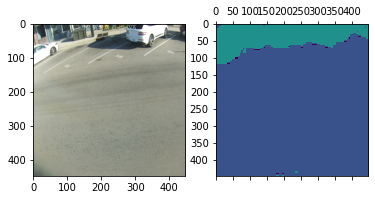

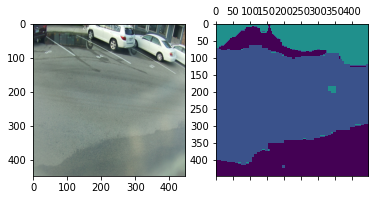

In [6]:
#as an idiot check, lets look at the output of the generator.
#for a full training batch... 

x,y = next(train_generator)

for count,(im,lab) in enumerate(zip(x, y)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(im)
    ax2.matshow(lab.squeeze(), vmin = 0, vmax = 4)


In [7]:
#the model
#first we define the inputs, which is the shape of images defined in teh code blocks above 
inputs = layers.Input(imshape)

# 'Honey I shrunk the kids"'
# now we set up 4 blocks of comvolutons in the 'encoder' part
#block1
conv1 = layers.Conv2D(7, 2, activation = 'relu', strides=(1,1), padding="same")(inputs)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#block2
conv2 = layers.Conv2D(14, 2, activation = 'relu', strides=(1,1), padding="same")(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#block3
conv3 = layers.Conv2D(28, 3, activation = 'relu', strides=(1,1), padding="same")(pool2)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

#block4
conv4 = layers.Conv2D(56, 3, activation = 'relu', strides=(1,1), padding="same")(pool3)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)


# we shrink as far as we are going to go...
#bottlneck
conv5 = layers.Conv2D(112, 2, activation = 'relu', strides=(1,1), padding="same")(pool4)

# # 'Honey I blew up the kids"... we upsample now
# #upblock 1
up6 = layers.UpSampling2D(2)(conv5)
conc6 = layers.concatenate([up6, conv4])
conv6 = layers.Conv2D(56, 3, activation = 'relu', strides=(1,1), padding="same")(conc6)

#upblock 2
up7 = layers.UpSampling2D(2)(conv6)
conc7 = layers.concatenate([up7, conv3])
conv7 = layers.Conv2D(28, 3, activation = 'relu', strides=(1,1), padding="same")(conc7)

#upblock 3
up8 = layers.UpSampling2D(2)(conv7)
conc8 = layers.concatenate([up8, conv2])
conv8 = layers.Conv2D(14, 3, activation = 'relu', strides=(1,1), padding="same")(conc8)

#upblock 4
up9 = layers.UpSampling2D(2)(conv8)
conc9 = layers.concatenate([up9, conv1])
conv9 = layers.Conv2D(7, 3, activation = 'relu', strides=(1,1), padding="same")(conc9)

#we define the outputs here
outputs = layers.Conv2D(num_classes, (1, 1), padding="same", activation="softmax")(conv9)


#combine the model together
model = Model(inputs, outputs)

#and print out the text summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 448, 448, 7)  91          ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 224, 224, 7)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 14  406         ['max_pooling2d[0][0]']      

In [8]:
# here is a graphic summary of the model... you can see the downsampling, bottleneck, and upsampling, connected to each other via skip connections
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [9]:
#we compile the model, set a loss function, and also an optimizer. 

model.compile( loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
             )

In [10]:
# define a callback, which runs during training and does something for us. 
#This one looks at the training loss, and stops the training if the loss does 
#not improve from some number of epochs. Then it reverts to the best version of 
# the model, where loss was lowest

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'loss', 
                                             patience = 10, 
                                             restore_best_weights = True)

In [11]:
#lets now train the model! We can store all teh model output in 'history'.
# note that we are using the training generator for training data, the val 
# generator for validation data, we set the model to train for some number of epochs, 
# we tell teh network how many steps there are to get through the entire data set
# and we also give the network our callback to use.

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 100,
                    workers = 8,
                    steps_per_epoch = total_train // batch_size,
                    validation_steps =  total_val // batch_size,
                    callbacks =[callbacks])

Epoch 1/100
9/9 [==============================] - 4s 47ms/step - loss: 1.0835 - val_loss: 1.1097
Epoch 2/100
9/9 [==============================] - 0s 29ms/step - loss: 1.0780 - val_loss: 1.1747
Epoch 3/100
9/9 [==============================] - 0s 29ms/step - loss: 1.0762 - val_loss: 1.2268
Epoch 4/100
9/9 [==============================] - 0s 29ms/step - loss: 1.0752 - val_loss: 1.1639
Epoch 5/100
9/9 [==============================] - 0s 29ms/step - loss: 1.0653 - val_loss: 1.0827
Epoch 6/100
9/9 [==============================] - 0s 28ms/step - loss: 1.0498 - val_loss: 1.0454
Epoch 7/100
9/9 [==============================] - 0s 31ms/step - loss: 1.0321 - val_loss: 1.0491
Epoch 8/100
9/9 [==============================] - 0s 29ms/step - loss: 1.0116 - val_loss: 0.9317
Epoch 9/100
9/9 [==============================] - 0s 30ms/step - loss: 0.9718 - val_loss: 0.9535
Epoch 10/100
9/9 [==============================] - 0s 28ms/step - loss: 0.9301 - val_loss: 0.9884
Epoch 11/100
9/9 [=

Epoch 84/100
9/9 [==============================] - 1s 94ms/step - loss: 0.5487 - val_loss: 1.6670
Epoch 85/100
9/9 [==============================] - 1s 103ms/step - loss: 0.7941 - val_loss: 1.0730
Epoch 86/100
9/9 [==============================] - 1s 103ms/step - loss: 0.7905 - val_loss: 1.4584
Epoch 87/100
9/9 [==============================] - 0s 44ms/step - loss: 0.7544 - val_loss: 1.0677
Epoch 88/100
9/9 [==============================] - 0s 33ms/step - loss: 0.6119 - val_loss: 1.3614
Epoch 89/100
9/9 [==============================] - 0s 31ms/step - loss: 0.5649 - val_loss: 1.1186
Epoch 90/100
9/9 [==============================] - 0s 30ms/step - loss: 0.5454 - val_loss: 1.5948
Epoch 91/100
9/9 [==============================] - 0s 30ms/step - loss: 0.5370 - val_loss: 1.0976
Epoch 92/100
9/9 [==============================] - 0s 35ms/step - loss: 0.5232 - val_loss: 1.3977
Epoch 93/100
9/9 [==============================] - 0s 44ms/step - loss: 0.5162 - val_loss: 1.9142
Epoch 94

<function matplotlib.pyplot.show(close=None, block=None)>

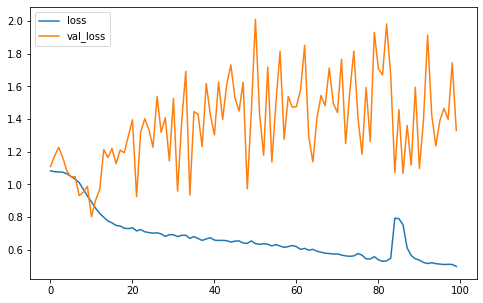

In [12]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
#plt.grid(True)
plt.show

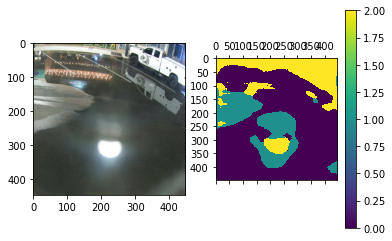

In [13]:
#lets look at the model prediction on a single image.

# here is the gdrive path to the image
imgp = 'data/segmentation/images/images/CAM_BF_01_20220518011222 copy_jmbolewitz.jpg'

#we pull the image and preprocess it — normalizing and making it a array/tensor
img = tf.keras.preprocessing.image.load_img(imgp,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
img = np.expand_dims(img,axis=0)

#We use the model to make a prediction on this image
pred = model.predict(img)

# we use argmax to get the labels for the image (recall the output of the 
# model is a tensor with shape of the image and then a depth equal to the 
# number of classes. this argmax and squeeze are here to collapse that).
lab = np.argmax(pred.squeeze(),-1)


#lets look at the model results and the image

imgUP = matplotlib.image.imread(imgp)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img.squeeze())
labels = ax2.matshow(lab)
cax = fig.colorbar(labels, ax = ax2)
plt.show()

# water: 0; road:1; neither : 2

In [14]:
filepath = './models/Unet_water_1'
model.save(filepath)

INFO:tensorflow:Assets written to: ./models/Unet_water_1\assets
